## Step 2

Data regarding daily factor returns are available here https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

We download the data in csv format, remove the first three rows that contain a textual description of the data and import it here.

In [228]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [4]:
daily_factor_data = pd.read_excel("F-F_Research_Data_5_Factors_2x3_daily.xlsx")

In [5]:
daily_factor_data.set_index("Year", inplace=True)

In [6]:
daily_factor_data.index = pd.to_datetime(daily_factor_data.index, format="%Y%m%d")

In [7]:
daily_factor_data

,Mkt-RF,SMB,HML,RMW,CMA,RF
Year,,,,,,
1963-07-01,-0.67,0.02,-0.35,0.03,0.13,0.012
1963-07-02,0.79,-0.28,0.28,-0.08,-0.21,0.012
1963-07-03,0.63,-0.18,-0.10,0.13,-0.25,0.012
1963-07-05,0.40,0.09,-0.28,0.07,-0.30,0.012
1963-07-08,-0.63,0.07,-0.20,-0.27,0.06,0.012
...,...,...,...,...,...,...
2024-12-24,1.11,-0.12,-0.05,-0.13,-0.37,0.017
2024-12-26,0.02,1.09,-0.19,-0.44,0.35,0.017
2024-12-27,-1.17,-0.44,0.56,0.41,0.03,0.017


The data contains returns for six factors over a period ranging from 1963 to 2024. Let us consider only the following five factors:
1. Mkt-RF
2. SMB
3. HML
4. RMW
5. CMA

Let us consider a three year time period from January 1st 2022, to December 31st 2024.

In [9]:
daily_factor_data = daily_factor_data.loc["2022-01-01":"2024-12-31"]

In [10]:
daily_factor_data

,Mkt-RF,SMB,HML,RMW,CMA,RF
Year,,,,,,
2022-01-03,0.73,0.42,0.80,-1.17,0.59,0.000
2022-01-04,-0.29,-0.08,3.64,0.63,1.47,0.000
2022-01-05,-2.28,-0.94,2.59,1.39,1.25,0.000
2022-01-06,0.00,0.38,1.75,-0.56,-0.01,0.000
2022-01-07,-0.48,-0.96,2.02,-0.12,0.85,0.000
...,...,...,...,...,...,...
2024-12-24,1.11,-0.12,-0.05,-0.13,-0.37,0.017
2024-12-26,0.02,1.09,-0.19,-0.44,0.35,0.017
2024-12-27,-1.17,-0.44,0.56,0.41,0.03,0.017


Let us now visualize the daily factor returns over this three-year time period.

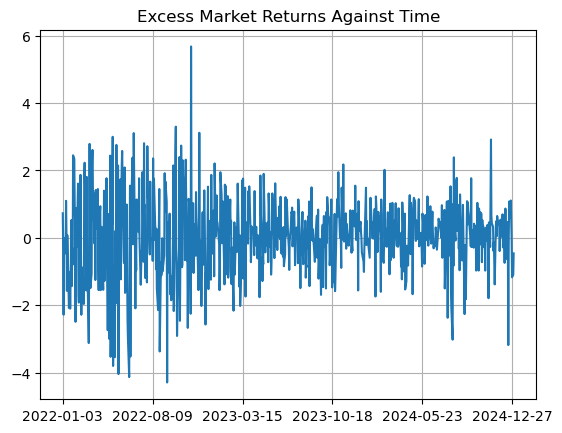

In [12]:
plt.plot(daily_factor_data["Mkt-RF"])
plt.grid()
plt.title("Excess Market Returns Against Time")
plt.xticks(pd.to_datetime(daily_factor_data.index[::150], format="%Y%m"));

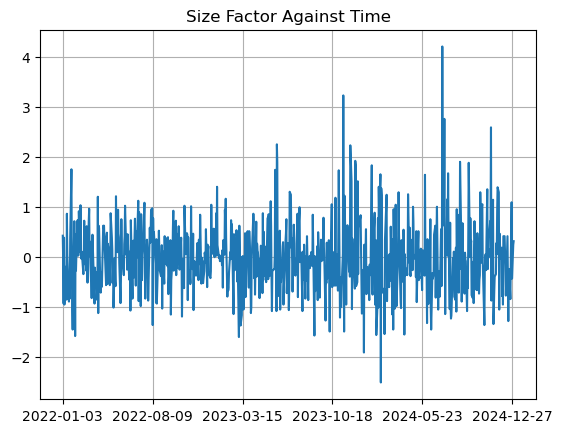

In [13]:
plt.plot(daily_factor_data["SMB"])
plt.grid()
plt.title("Size Factor Against Time")
plt.xticks(pd.to_datetime(daily_factor_data.index[::150], format="%Y%m"));

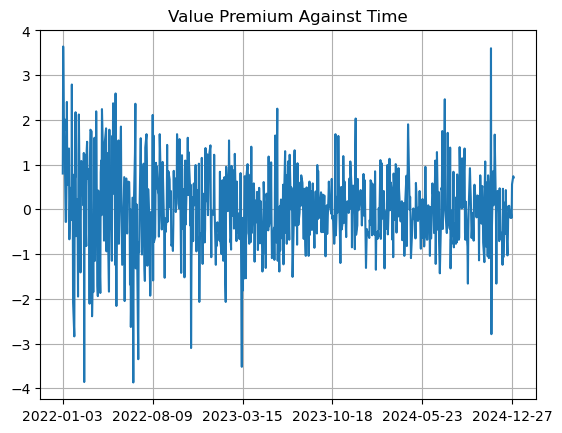

In [14]:
plt.plot(daily_factor_data["HML"])
plt.grid()
plt.title("Value Premium Against Time")
plt.xticks(pd.to_datetime(daily_factor_data.index[::150], format="%Y%m"));

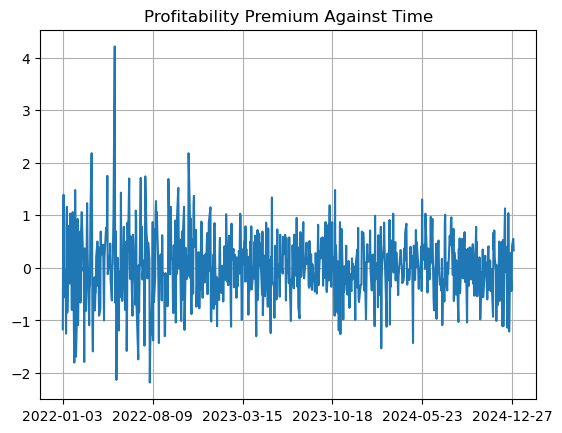

In [15]:
plt.plot(daily_factor_data["RMW"])
plt.grid()
plt.title("Profitability Premium Against Time")
plt.xticks(pd.to_datetime(daily_factor_data.index[::150], format="%Y%m"));

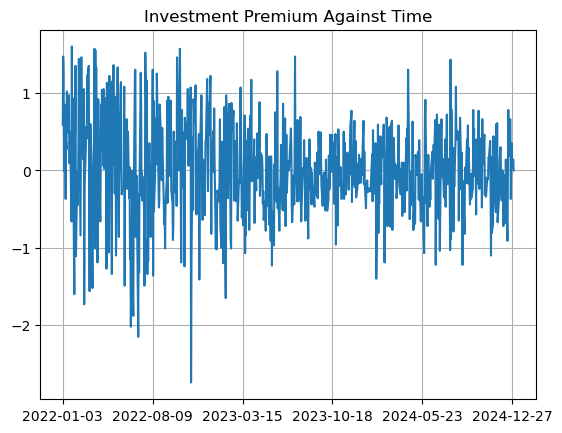

In [16]:
plt.plot(daily_factor_data["CMA"])
plt.grid()
plt.title("Investment Premium Against Time")
plt.xticks(pd.to_datetime(daily_factor_data.index[::150], format="%Y%m"));

Let us compute the correlations of the factor returns

In [18]:
daily_factor_data.corr()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Mkt-RF,1.000000,0.218657,-0.391141,-0.372612,-0.471425,0.067500
SMB,0.218657,1.000000,0.134794,-0.430618,-0.086428,-0.010683
HML,-0.391141,0.134794,1.000000,0.356232,0.646585,-0.059453
RMW,-0.372612,-0.430618,0.356232,1.000000,0.295510,0.002866
CMA,-0.471425,-0.086428,0.646585,0.295510,1.000000,-0.093562
RF,0.067500,-0.010683,-0.059453,0.002866,-0.093562,1.000000


Let us provide a heatmap visualization for this table of correlations

<Axes: >

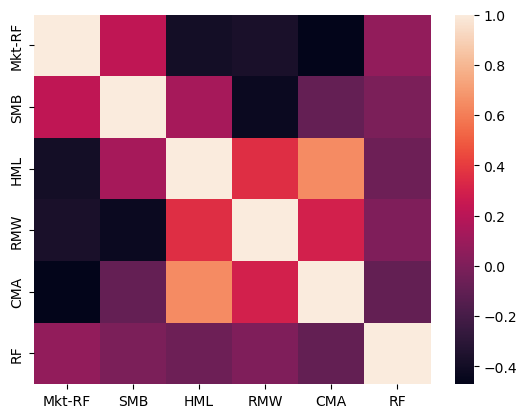

In [20]:
sns.heatmap(daily_factor_data.corr())

Now, our task is to collect some economic data for this period

Crude Oil Prices - daily https://fred.stlouisfed.org/series/DCOILWTICO

Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (DGS10) https://fred.stlouisfed.org/series/DGS10


## Step 3

Let us take the apple stock as an example and find the FF3 betas using Linear Regression

In [244]:
stock_data = yf.download("AAPL", start="2021-12-31", end="2025-01-01")

[*********************100%***********************]  1 of 1 completed


In [246]:
stock_data

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2021-12-31,174.516281,176.147722,174.211600,175.027328,64062300
2022-01-03,178.879913,179.734962,174.653874,174.771805,104487900
2022-01-04,176.609634,179.793920,176.039607,179.489254,99310400
2022-01-05,171.911835,177.071549,171.636651,176.521181,94537600
2022-01-06,169.042068,172.285320,168.688259,169.730027,96904000
...,...,...,...,...,...
2024-12-24,257.916443,257.926411,255.009620,255.209412,23234700
2024-12-26,258.735504,259.814335,257.347047,257.906429,27237100


In [248]:
y = stock_data["Close"].pct_change().dropna()*100

Let us take the apple stock as an example and find the FF5 betas using Linear Regression

In [251]:
y #daily stock returns in percentage terms

Ticker,AAPL
Date,
2022-01-03,2.500416
2022-01-04,-1.269164
2022-01-05,-2.659991
2022-01-06,-1.669324
2022-01-07,0.098823
...,...
2024-12-24,1.147807
2024-12-26,0.317568
2024-12-27,-1.324213


In [293]:
X = daily_factor_data[["Mkt-RF", "SMB",	"HML"]]

In [295]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [297]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [259]:
model = sm.OLS(y_train, X_train).fit()

In [261]:
y_pred = model.predict(X_test)

In [263]:
r2_score(y_pred, y_test)

-0.2407466019132567

In [265]:
r2_score(y_train, model.predict(X_train))

0.6821173697496608

In [267]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   AAPL   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     427.7
Date:                Tue, 29 Apr 2025   Prob (F-statistic):          2.43e-148
Time:                        11:41:04   Log-Likelihood:                -853.77
No. Observations:                 602   AIC:                             1716.
Df Residuals:                     598   BIC:                             1733.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0126      0.041      0.309      0.758      -0.068       0.093
Mkt-RF         1.1384      0.038     29.579      0.000       1.063       1.214
SMB           -0.2977      0.063     -4.754      0.000      -0.421      -0.175
HML           -0.2395      0.047     -5.082      0.000      -0.332      -0.147
==============================================================================
Omnibus:                       53.411   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              279.870
Skew:                           0.093   Prob(JB):                     1.69e-61
Kurtosis:                       6.335   Cond. No.                         2.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now let us try Robust Linear Regression

In [301]:
model = sm.RLM(y_train, X_train).fit()

In [303]:
y_pred = model.predict(X_test)

In [305]:
r2_score(y_pred, y_test)

-0.29589208347589135

In [307]:
r2_score(y_train, model.predict(X_train))

0.6815958469332709

In [309]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                   AAPL   No. Observations:                  602
Model:                            RLM   Df Residuals:                      598
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 29 Apr 2025                                         
Time:                        11:53:30                                         
No. Iterations:                    16                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0174      0.034      0.516      0.606      -0.049       0.084
Mkt-RF         1.1099      0.032     34.927      0.000       1.048       1.172
SMB           -0.3007      0.052     -5.815      0.000      -0.402      -0.199
HML           -0.2290      0.039     -5.884      0.000      -0.305      -0.153
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

## Step 4

In [311]:
X = daily_factor_data[["Mkt-RF", "SMB",	"HML", "RMW", "CMA"]]
X

,Mkt-RF,SMB,HML,RMW,CMA
Year,,,,,
2022-01-03,0.73,0.42,0.80,-1.17,0.59
2022-01-04,-0.29,-0.08,3.64,0.63,1.47
2022-01-05,-2.28,-0.94,2.59,1.39,1.25
2022-01-06,0.00,0.38,1.75,-0.56,-0.01
2022-01-07,-0.48,-0.96,2.02,-0.12,0.85
...,...,...,...,...,...
2024-12-24,1.11,-0.12,-0.05,-0.13,-0.37
2024-12-26,0.02,1.09,-0.19,-0.44,0.35
2024-12-27,-1.17,-0.44,0.56,0.41,0.03


Now, let us find the betas for the factors by regressing the daily stock returns on them.

We split the train and test sets chronologically. The first 80% of the data points are slotted in the train set, and the remainder in the test set.

In [313]:
y_train

Ticker,AAPL
Date,
2022-01-03,2.500416
2022-01-04,-1.269164
2022-01-05,-2.659991
2022-01-06,-1.669324
2022-01-07,0.098823
...,...
2024-05-20,0.616201
2024-05-21,0.685732
2024-05-22,-0.753835


In [315]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [317]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [319]:
X_train

,const,Mkt-RF,SMB,HML,RMW,CMA
Year,,,,,,
2022-01-03,1.0,0.73,0.42,0.80,-1.17,0.59
2022-01-04,1.0,-0.29,-0.08,3.64,0.63,1.47
2022-01-05,1.0,-2.28,-0.94,2.59,1.39,1.25
2022-01-06,1.0,0.00,0.38,1.75,-0.56,-0.01
2022-01-07,1.0,-0.48,-0.96,2.02,-0.12,0.85
...,...,...,...,...,...,...
2024-05-20,1.0,0.14,0.16,-0.88,0.15,-0.66
2024-05-21,1.0,0.15,-0.43,0.19,0.41,-0.31
2024-05-22,1.0,-0.35,-0.40,-0.38,-0.44,-0.05


In [281]:
model = sm.OLS(y_train, X_train).fit()

In [283]:
y_pred = model.predict(X_test)

In [285]:
r2_score(y_test, y_pred)

0.2240590671214202

In [287]:
r2_score(y_train, model.predict(X_train))

0.7059768342175827

In [289]:
model.params

const     0.013676
Mkt-RF    1.234829
SMB      -0.105133
HML      -0.570806
RMW       0.357829
CMA       0.544287
dtype: float64

In [291]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   AAPL   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     286.2
Date:                Tue, 29 Apr 2025   Prob (F-statistic):          8.75e-156
Time:                        11:42:33   Log-Likelihood:                -830.28
No. Observations:                 602   AIC:                             1673.
Df Residuals:                     596   BIC:                             1699.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0137      0.039      0.347      0.729      -0.064       0.091
Mkt-RF         1.2348      0.040     30.886      0.000       1.156       1.313
SMB           -0.1051      0.069     -1.533      0.126      -0.240       0.030
HML           -0.5708      0.068     -8.405      0.000      -0.704      -0.437
RMW            0.3578      0.074      4.864      0.000       0.213       0.502
CMA            0.5443      0.103      5.263      0.000       0.341       0.747
==============================================================================
Omnibus:                       44.553   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              196.682
Skew:                           0.022   Prob(JB):                     1.95e-43
Kurtosis:                       5.800   Cond. No.                         4.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now let us try robust linear regression

In [322]:
model = sm.RLM(y_train, X_train).fit()

In [324]:
y_pred = model.predict(X_test)

In [326]:
r2_score(y_test, y_pred)

0.2653060258519431

In [328]:
r2_score(y_train, model.predict(X_train))

0.7044650991387293

In [330]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                   AAPL   No. Observations:                  602
Model:                            RLM   Df Residuals:                      596
Method:                          IRLS   Df Model:                            5
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 29 Apr 2025                                         
Time:                        11:58:12                                         
No. Iterations:                    16                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0181      0.034      0.536      0.592      -0.048       0.084
Mkt-RF         1.1860      0.034     34.610      0.000       1.119       1.253
SMB           -0.1377      0.059     -2.343      0.019      -0.253      -0.023
HML           -0.4891      0.058     -8.402      0.000      -0.603      -0.375
RMW            0.2968      0.063      4.707      0.000       0.173       0.420
CMA            0.4115      0.089      4.643      0.000       0.238       0.585
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""